In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Chapter 8 - Tree-Based Methods

#### Gini index pg.312

A measure of total variance across classes.

$$
G = \sum_{k=1}^{K} p_{mk} (1-p_{mk}) 
$$

Here, $p_{mk}$ represents the proportion of a training observations in the *_m_*th region that from the *_k_*th class.

Gini index takes on a small value if all of the x's are close to zero or one. (see below). For this reason the Gini index is referred to as a measure of node *_purity_* - a small value indicates that a node contains predominantly observations from a single class.

In [209]:
# Gini index for 0-1
for x in np.linspace(0,1,11):
    print(round(x,1), (round(x*(1-x),2)))

0.0 0.0
0.1 0.09
0.2 0.16
0.3 0.21
0.4 0.24
0.5 0.25
0.6 0.24
0.7 0.21
0.8 0.16
0.9 0.09
1.0 0.0


# Lab: Decision Trees

### 8.3.1 Fitting Classification Trees

In [2]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Carseats.csv")

df=df.drop(columns=['Unnamed: 0'])
print("Shape of df: " + str(df.shape))
df.head()

Shape of df: (400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [3]:
df.describe(include='object')

,ShelveLoc,Urban,US
count,400,400,400
unique,3,2,2
top,Medium,Yes,Yes
freq,219,282,258


In [4]:
df['High'] = np.where(df['Sales'] <= 8, 0, 1)
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0


In [5]:
# pd.get_dummies with drop_first parameter

df = pd.get_dummies(df, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)

X = df.drop(['Sales', 'High'], axis=1).astype('float64')
y = df.High

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
CompPrice           400 non-null float64
Income              400 non-null float64
Advertising         400 non-null float64
Population          400 non-null float64
Price               400 non-null float64
Age                 400 non-null float64
Education           400 non-null float64
ShelveLoc_Good      400 non-null float64
ShelveLoc_Medium    400 non-null float64
Urban_Yes           400 non-null float64
US_Yes              400 non-null float64
dtypes: float64(11)
memory usage: 34.5 KB


In [6]:
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,High,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,9.50,138,73,11,276,120,42,17,1,0,0,1,1
1,11.22,111,48,16,260,83,65,10,1,1,0,1,1
2,10.06,113,35,10,269,80,59,12,1,0,1,1,1
3,7.40,117,100,4,466,97,55,14,0,0,1,1,1
4,4.15,141,64,3,340,128,38,13,0,0,0,1,0


Pruning is not currently supported in `sklearn`, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

See under advantages and disadvantages in `sklearn` [documentation](https://scikit-learn.org/stable/modules/tree.html).

In [7]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0, max_depth=6)

In [64]:
clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [65]:
# for classification trees

conf_matrix = pd.crosstab(clf.predict(X), y, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
terminal_nodes = len(np.unique(clf.apply(X)))

print("Number of terminal nodes: " + str(terminal_nodes))
print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
conf_matrix

Number of terminal nodes: 35
Error rate (misclassification): 0.08 = 32 / 400
Accuracy: 0.92


Actual,0,1,All
Predicted,,,
0,235,31,266
1,1,133,134
All,236,164,400


In [11]:
# all nodes
clf.tree_.node_count

69

In [53]:
# get terminal nodes
# https://stackoverflow.com/questions/30408046/finding-a-corresponding-leaf-node-for-each-data-point-in-a-decision-tree-scikit
terminal_nodes = len(np.unique(clf.apply(X)))
terminal_nodes

35

In [14]:
pd.Series(clf.feature_importances_, X.columns).sort_values(ascending=False)

Price               0.340111
ShelveLoc_Good      0.195602
Income              0.114517
CompPrice           0.080645
ShelveLoc_Medium    0.073516
Advertising         0.070167
Age                 0.065594
Population          0.046733
US_Yes              0.007717
Urban_Yes           0.005397
Education           0.000000
dtype: float64

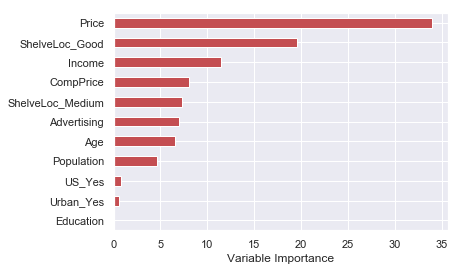

In [15]:
Importance = pd.DataFrame({'Importance':clf.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [22]:
from sklearn.tree import export_graphviz
import graphviz

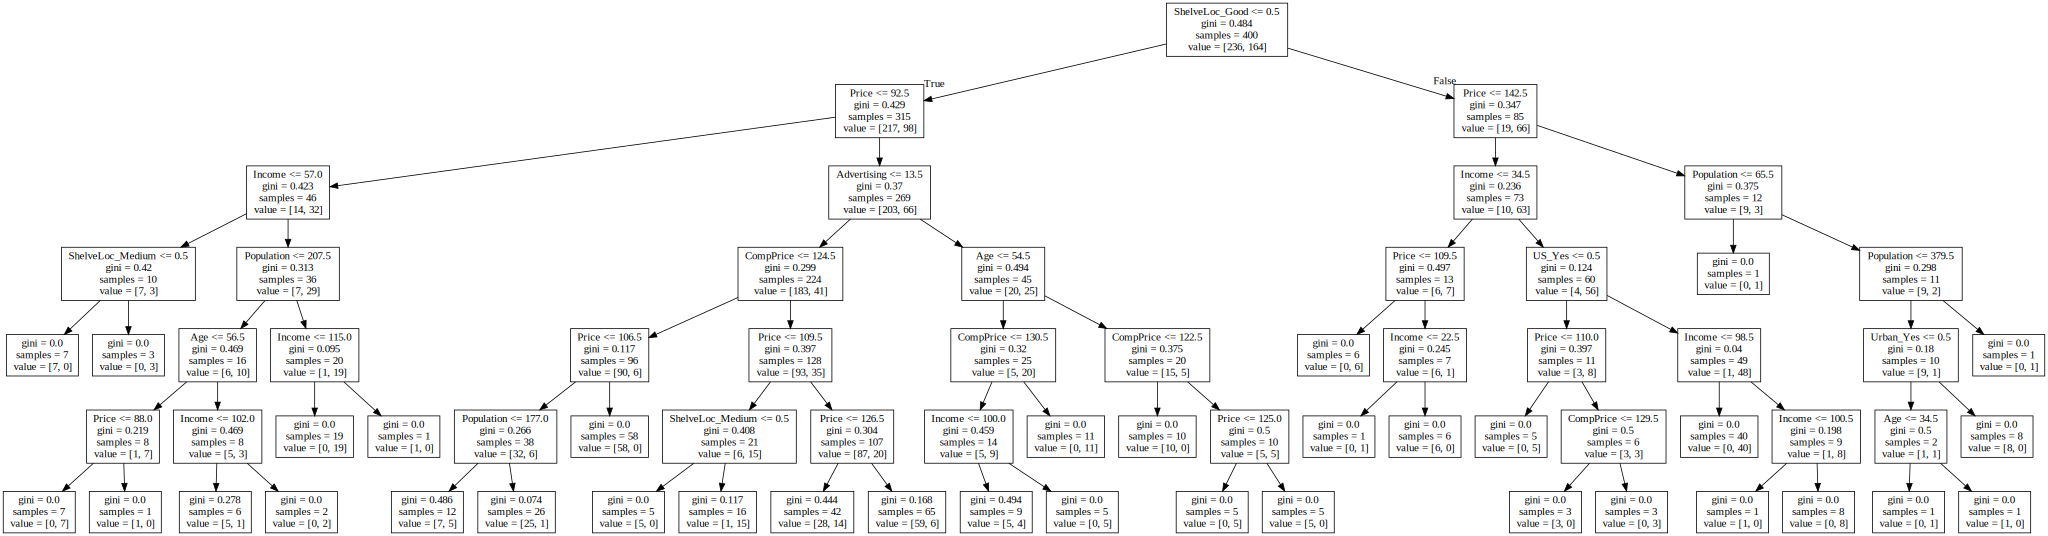

In [24]:
export_graphviz(clf, out_file="mytree.dot", feature_names=X.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [67]:
# evaluate on test set pg. 325-326
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

clf_t = DecisionTreeClassifier(random_state=0, max_depth=6)

clf_t.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [68]:
# evaluation on test set
# for classification trees

conf_matrix = pd.crosstab(clf_t.predict(X_test), y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
terminal_nodes = len(np.unique(clf_t.apply(X)))

print("Number of terminal nodes: " + str(terminal_nodes))
print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
conf_matrix

Number of terminal nodes: 29
Error rate (misclassification): 0.265 = 53 / 200
Accuracy: 0.735


Actual,0,1,All
Predicted,,,
0,103,38,141
1,15,44,59
All,118,82,200


In [ ]:
# pruning via CV. goal to get correct 'max_leafs' (terminal nodes)
# different answer than from book

from sklearn.model_selection import cross_val_score

scores = []
max_leafs_arr = range(2, 50)
for max_leafs in max_leafs_arr:
    regressionTree = DecisionTreeClassifier(max_leaf_nodes=max_leafs)
    sc = cross_val_score(regressionTree, X, y, cv=10)
    scores.append((sc.mean(), sc.std()))
scores = np.array(scores)

The best tree has 4 leafs.


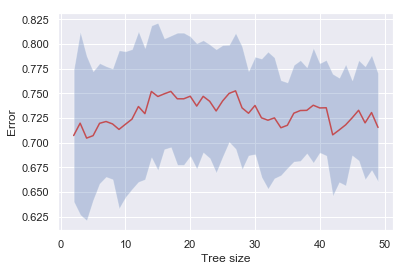

In [89]:
plt.plot(max_leafs_arr, scores[:,0], 'r')
plt.fill_between(max_leafs_arr, scores[:,0]+scores[:,1], scores[:,0]-scores[:,1], alpha=0.3)
plt.xlabel('Tree size')
plt.ylabel('Error')
best_min_leafs = max_leafs_arr[np.argmin(scores[:,0])]
print(f"The best tree has {best_min_leafs} leafs.")

In [98]:
clf_cv = DecisionTreeClassifier(random_state=0, max_leaf_nodes=4)

clf_cv.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [99]:
# for classification trees
# pruning via CV
# model does not improve on test error. this is diff than from book

conf_matrix = pd.crosstab(clf_cv.predict(X_test), y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
terminal_nodes = len(np.unique(clf_cv.apply(X)))

print("Number of terminal nodes: " + str(terminal_nodes))
print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
conf_matrix

Number of terminal nodes: 4
Error rate (misclassification): 0.31 = 62 / 200
Accuracy: 0.69


Actual,0,1,All
Predicted,,,
0,102,46,148
1,16,36,52
All,118,82,200


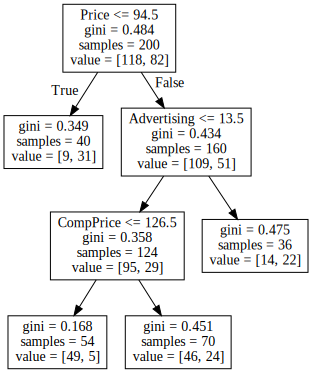

In [88]:
export_graphviz(clf_cv, out_file="mytree.dot", feature_names=X.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## 8.3.2 Fitting Regression Trees

In [106]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/MASS/Boston.csv").drop(df.columns[0], axis=1)
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [110]:
X = df.iloc[:, :-1]
y = df['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [115]:
from sklearn.tree import DecisionTreeRegressor


dtreg = DecisionTreeRegressor(random_state=0, max_depth=3)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

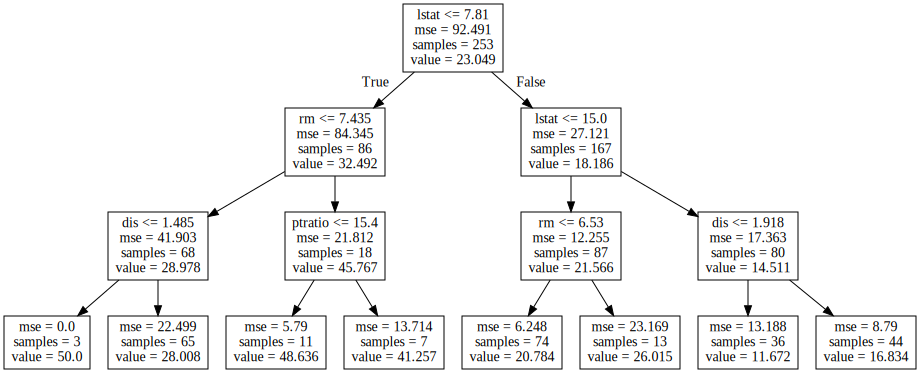

In [116]:
export_graphviz(dtreg, out_file="mytree.dot", feature_names=X.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [120]:
# number of terminal nodes
len(np.unique(dtreg.apply(X)))

8

In [126]:
# residual mean deviance
1-dtreg.score(X_train, y_train)

0.13876614731618253

In [125]:
from sklearn.metrics import mean_squared_error

pred = dtreg.predict(X_test)
mean_squared_error(y_test, pred)

26.02323085009744

## 8.3.3 Bagging and Random Forests

In [164]:
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(random_state=1, max_features=13).fit(X_train, y_train)

In [165]:
pred = bag_reg.predict(X_test)
mean_squared_error(y_test, pred)

18.037680632411067

Text(0,0.5,'y_test')

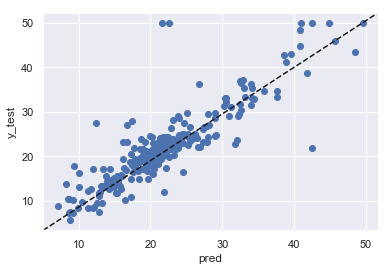

In [166]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

MSE comparison of RF and Bag depend closely on the seed (random_state). When `random_state=0` is used, Bagging comes out slighly ahead. When `random_state=1` is used, RF comes out ahead.

In [167]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=1, max_features=6).fit(X_train, y_train)

In [168]:
pred = rf.predict(X_test)
mean_squared_error(y_test, pred)

16.469374703557314

In [169]:
pd.Series(rf.feature_importances_, X.columns).sort_values(ascending=False)

lstat      0.450108
rm         0.291252
dis        0.060799
crim       0.050050
nox        0.039058
tax        0.032206
ptratio    0.020210
age        0.019392
black      0.012868
indus      0.011538
rad        0.006838
chas       0.003970
zn         0.001711
dtype: float64

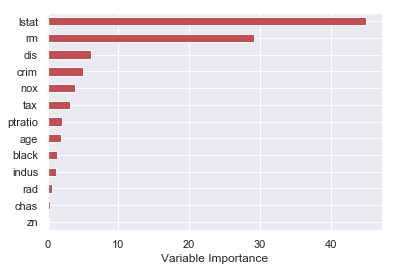

In [170]:
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 8.3.4 Boosting

In [196]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=1, learning_rate=0.001,
                               max_depth=4, n_estimators=5000).fit(X_train, y_train)

In [197]:
pd.Series(rf.feature_importances_, X.columns).sort_values(ascending=False)

lstat      0.450108
rm         0.291252
dis        0.060799
crim       0.050050
nox        0.039058
tax        0.032206
ptratio    0.020210
age        0.019392
black      0.012868
indus      0.011538
rad        0.006838
chas       0.003970
zn         0.001711
dtype: float64

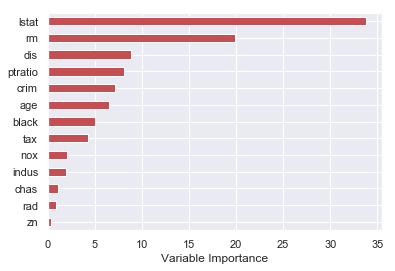

In [198]:
Importance = pd.DataFrame({'Importance':gbr.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

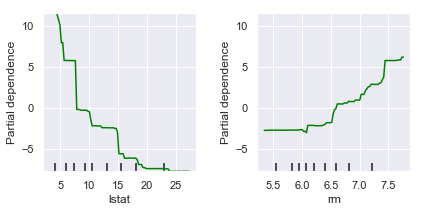

In [199]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

fig,axs = plot_partial_dependence(gbr, X_train, features=[12,5],
                                 feature_names=X_train.columns,
                                 grid_resolution=100)

In [200]:
pred = gbr.predict(X_test)
mean_squared_error(y_test, pred)

17.513516441808154

In [201]:
# adjust the learning rate/shrinkage
gbr2 = GradientBoostingRegressor(random_state=1, learning_rate=0.2,
                               max_depth=4, n_estimators=5000).fit(X_train, y_train)

In [202]:
# mse improves slightly
pred = gbr2.predict(X_test)
mean_squared_error(y_test, pred)

17.21390293710453